# 50.038 Computational Data Science project

Group members:<br />Kenny Ong Ker Chin 1005290 <br />Jobelle Lee Ern Ee 1005547<br />Baarath S/O Sellathurai 1005433

## Problem

The problem is to predict the prices of public housing units in Singapore based on their characteristics. This will help potential buyers and sellers to make informed decisions about the market value of their properties.

## Dataset

The Housing and Development Board provides data on the resale price of the flats as well as relevant data that might impact these prices.<br />
Coverage of the data is from January 1, 2017 to March 5, 2023.<br />
The dataset includes information on the location, type, size, and age of the units. <a href='https://data.gov.sg/dataset/resale-flat-prices'>https://data.gov.sg/dataset/resale-flat-prices</a>

In [ ]:
# Importing the libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")

# Resale Flat Prices data
url = "https://data.gov.sg/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3"

<h1>Data Visualization</h1>

In [ ]:
# Methods to get data from API
def searchData(url, keyword):
    results = pd.DataFrame()
    data = requests.get(f"{url}&q={keyword}").json()
    results.append(data['result']['records'])
    
    while data['result']['_links']['next']:
        data = requests.get("https://data.gov.sg/" + data['result']['_links']['next']).json()
        results.append(data['result']['records'])

    return results

def limitData(url, limitNum):
    data = requests.get(f"{url}&limit={limitNum}").json()
    return data['result']['records']


In [ ]:
df = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv") # OR USE searchData/limitData
print(df.dtypes)
df.head(2)

In [ ]:
df['year'] = df['month'].apply(lambda x: x.split('-')[0]).astype(int)
df['month'] = df['month'].apply(lambda x: x.split('-')[1]).astype(int)

# Convert remaining lease from years to months
df['month_remaining_lease'] = df['remaining_lease'].apply(lambda x: int(x.split(' ')[0]) * 12 + int(x.split(' ')[2]) if len(x.split(' ')) > 2 else int(x.split(' ')[0]) * 12)

# Split storey_range into 2 columns
df['storey_range_low'] = df['storey_range'].apply(lambda x: int(x.split(' TO ')[0]))
df['storey_range_high'] = df['storey_range'].apply(lambda x:int(x.split(' TO ')[1]))


In [ ]:
# Set up the matplotlib figure
sns.set_style('whitegrid')

In [ ]:
# Compute the correlation matrix
corr = df.corr()
print(corr)

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df.corr())

### Analyzing Categorical Column: town

In [ ]:
# for each month and year, plot the mean price into line chart with legend
def query_mean_plot_by_town(town):
    df[df['town'] == town].groupby(['year', 'month']).mean()['resale_price'].plot(label=town)
    plt.legend()
    
query_mean_plot_by_town('WOODLANDS')
query_mean_plot_by_town('ANG MO KIO')

In [ ]:
df.town.value_counts(normalize=True).plot(kind='bar', title='Town')

In [ ]:
# For each town, plot lease_commence_date against resale price
def plot_date_agst_price(town):
    sns.scatterplot(x='lease_commence_date', y='resale_price', data=df[df['town'] == town])
    plt.title(town)
    

plot_date_agst_price('WOODLANDS')
plot_date_agst_price('ANG MO KIO')

### Analyzing Categorical Column: flat_type

In [ ]:
df.flat_type.value_counts(normalize=True).plot(kind='bar', title='Flat Type')

In [ ]:
f, ax = plt.subplots(figsize=(20, 9))

def plot_year_against_price(town):
    sns.barplot(data=df[df['town'] == town], x="year", y="resale_price", hue="flat_type", hue_order=df.flat_type.unique())
    plt.title(town)
        
plt.subplot(131)
plot_year_against_price('WOODLANDS')
plt.subplot(132)
plot_year_against_price('ANG MO KIO')
plt.subplot(133)
plot_year_against_price('YISHUN')
    

### Line Plots of Continuous Variables

In [ ]:
# line plot of lease commence date and resale price
sns.lineplot(x='lease_commence_date', y='resale_price', data=df)
plt.title('Resale Price over Time')
plt.xlabel('Lease Commence Date')
plt.ylabel('Resale Price (SGD)')
plt.show()

# scatter plot of remaining lease and resale price
sns.scatterplot(x='remaining_lease', y='resale_price', hue='flat_type', data=df)
plt.title('Resale Price vs. Remaining Lease')
plt.xlabel('Remaining Lease (years)')
plt.ylabel('Resale Price (SGD)')
plt.show()

# scatter plot of floor area vs. resale price, colored by flat type
sns.scatterplot(x='floor_area_sqm', y='resale_price', hue='flat_type', data=df)
plt.title('Resale Price by Floor Area and Flat Type')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (SGD)')
plt.show()

# heatmap of correlation between numerical features
corr = df[['floor_area_sqm', 'remaining_lease', 'storey_range_high', 'resale_price']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between Numerical Features')
plt.show()

<h1>Algorithm</h1>

In [423]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

class PredictionModel:
    def __init__(self, regressor_type):
        self.features = ['floor_area_sqm', 'lease_commence_date', 'month_remaining_lease']
        self.y_col = 'resale_price'
        self.regressor_type = regressor_type
    
    def train_model(self, town, flat_type):
        target_df = df[(df['town'] == town) & (df['flat_type'] == flat_type)]
        y = target_df[self.y_col]
        X = target_df[self.features]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return True

    def fit(self):
        if self.regressor_type == "DecisionTreeRegressor":
            regressor = DecisionTreeRegressor(random_state=46)
        elif self.regressor_type == "RandomForestRegressor":
            regressor = RandomForestRegressor(n_estimators=100, random_state=48)
        elif self.regressor_type == "LinearRegression":
            regressor = LinearRegression(fit_intercept=True)
        elif self.regressor_type == "GradientBoostingRegressor":
            regressor = GradientBoostingRegressor()
        
        return regressor.fit(self.X_train, self.y_train)
    
    def predict(self, regressor):
        return regressor.predict(self.X_test)

    def evaluate(self, y_pred):
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        print("Mean Squared Error: {:.4f}".format(rmse))
        r2 = r2_score(self.y_test, y_pred)
        print("R2 score: {}".format(r2))
        
        plt.figure(figsize=(10,10))
        plt.scatter(self.y_test, y_pred, c='crimson')
        plt.yscale('log')
        plt.xscale('log')

        p1 = max(max(y_pred), max(self.y_test))
        p2 = min(min(y_pred), min(self.y_test))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('True Values', fontsize=15)
        plt.ylabel('Predictions', fontsize=15)
        plt.axis('equal')
        plt.show()

    
    def plot_importance(self, regressor):
        fig, ax = plt.subplots(figsize=(10, 6))
        importances = pd.Series(data=regressor.feature_importances_, index=self.X_train.columns)
        importances_sorted = importances.sort_values()
        importances_sorted.plot(kind='barh', color='lightgreen')
        plt.title('Features Importances')
        plt.show()
    
    
    def plot_permutation(self, regressor):
        fig, ax = plt.subplots(figsize=(10, 6))
        result = permutation_importance(regressor, self.X_test, self.y_test, n_repeats=10, random_state=42, n_jobs=2)
        sorted_idx = result.importances_mean.argsort()
        plt.boxplot(
            result.importances[sorted_idx].T,
            vert=False,
            labels=np.array(self.features)[sorted_idx],
        )
        plt.title("Permutation Importance (test set)")
        plt.show()

WOODLANDS - 4 ROOM
Mean Squared Error: 30102.5024
R2 score: 0.8204973815957478


<Figure size 600x600 with 0 Axes>

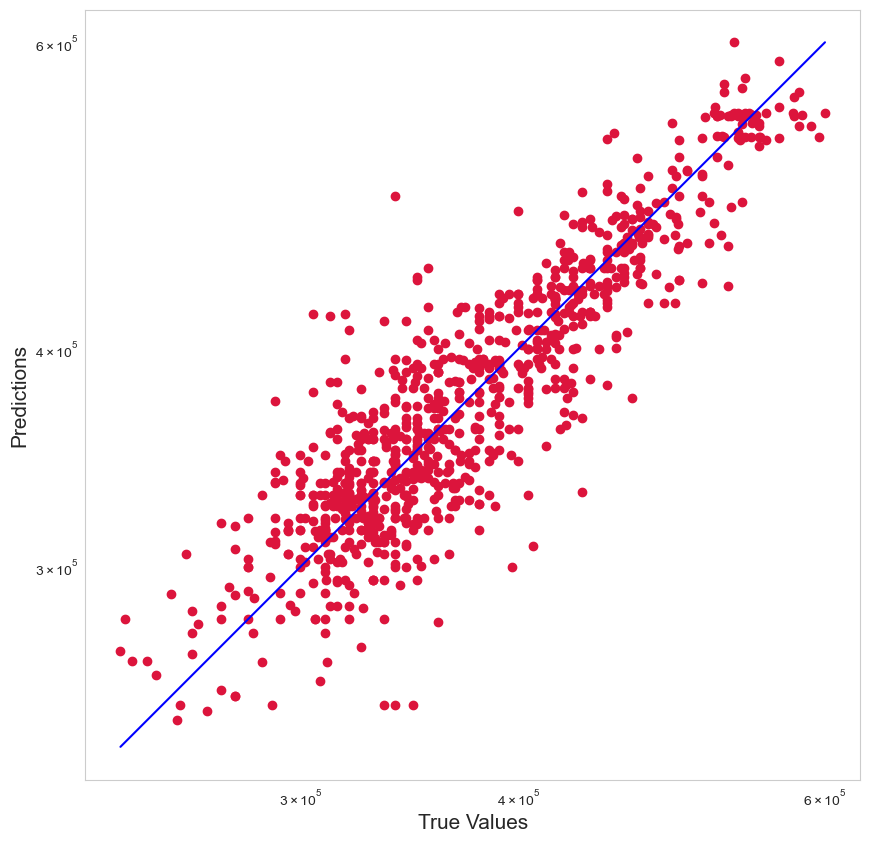

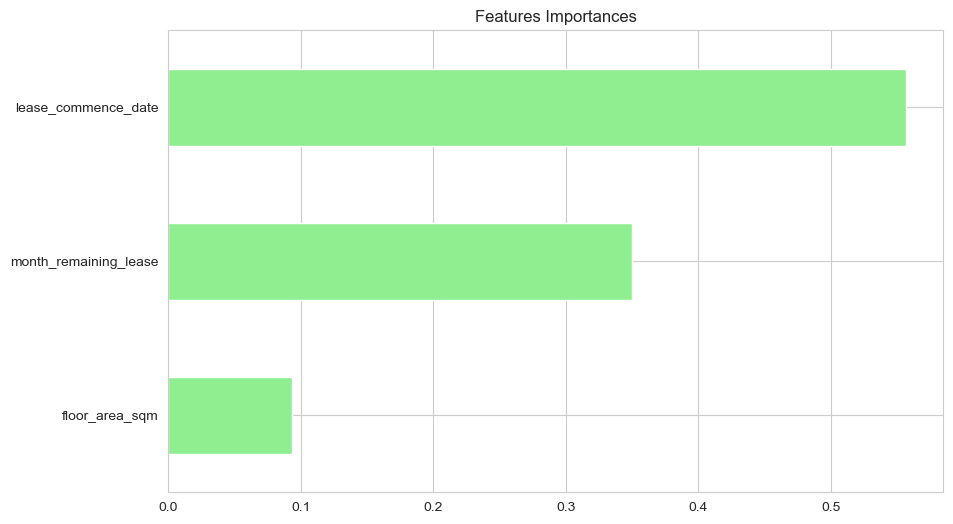

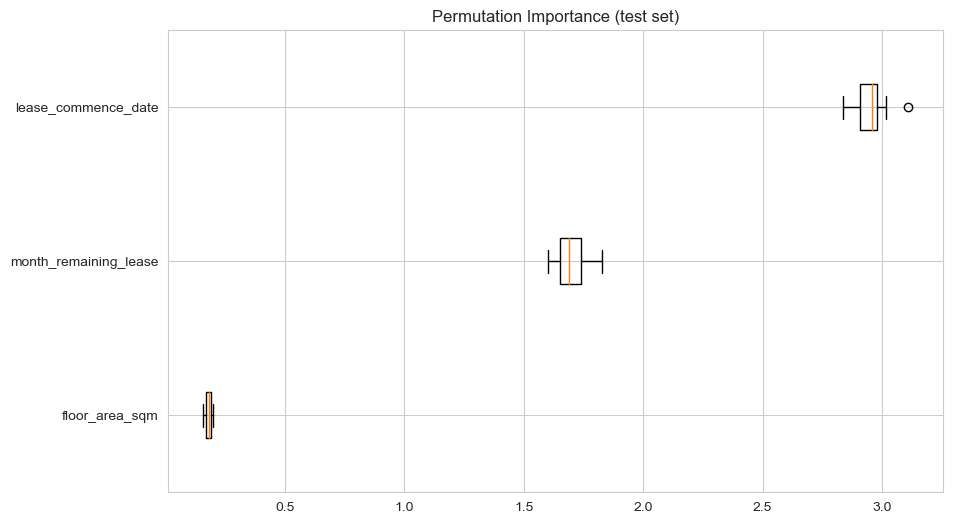

In [424]:
town = 'WOODLANDS'
flat_type = '4 ROOM'

fig = plt.figure(figsize=(6, 6))
# Decision Tree Regressor
print(town, "-", flat_type)
decision_tree_model = PredictionModel('DecisionTreeRegressor')
decision_tree_model.train_model(town, flat_type)
decision_tree_regressor = decision_tree_model.fit()
y_pred = decision_tree_model.predict(decision_tree_regressor)
decision_tree_model.evaluate(y_pred)
decision_tree_model.plot_importance(decision_tree_regressor)
decision_tree_model.plot_permutation(decision_tree_regressor)

WOODLANDS - 4 ROOM
Mean Squared Error: 25589.8171
R2 score: 0.8702820870392907


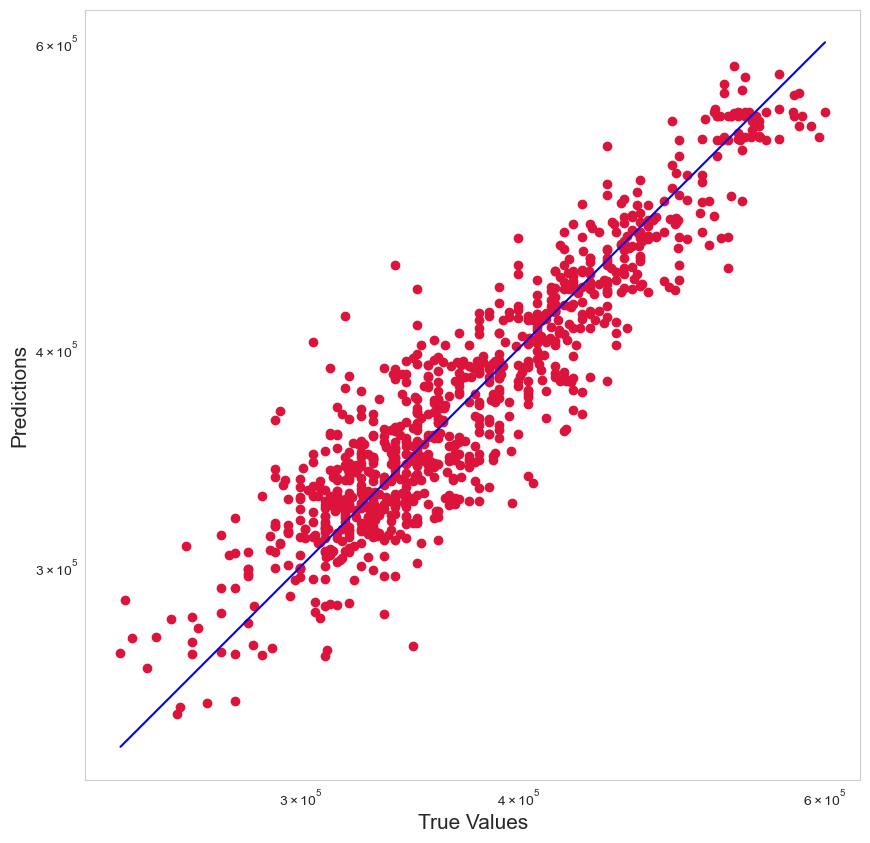

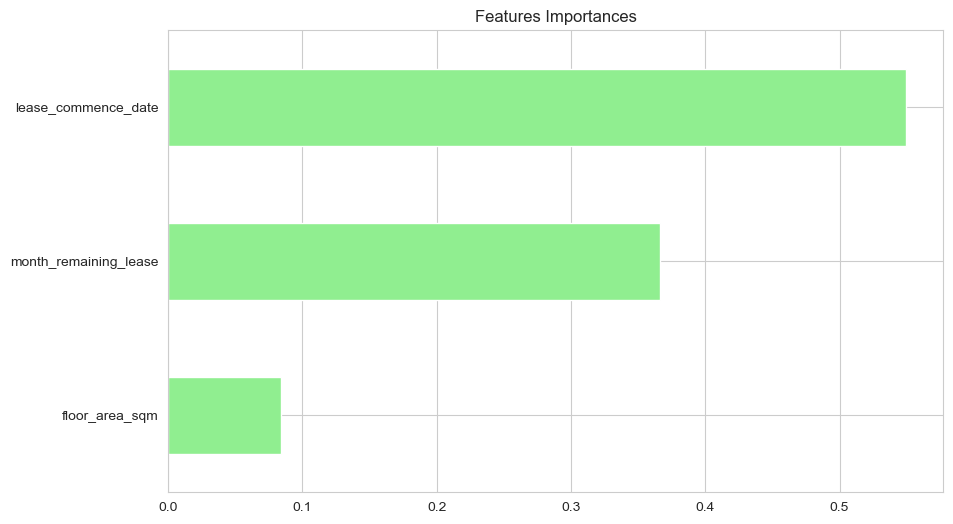

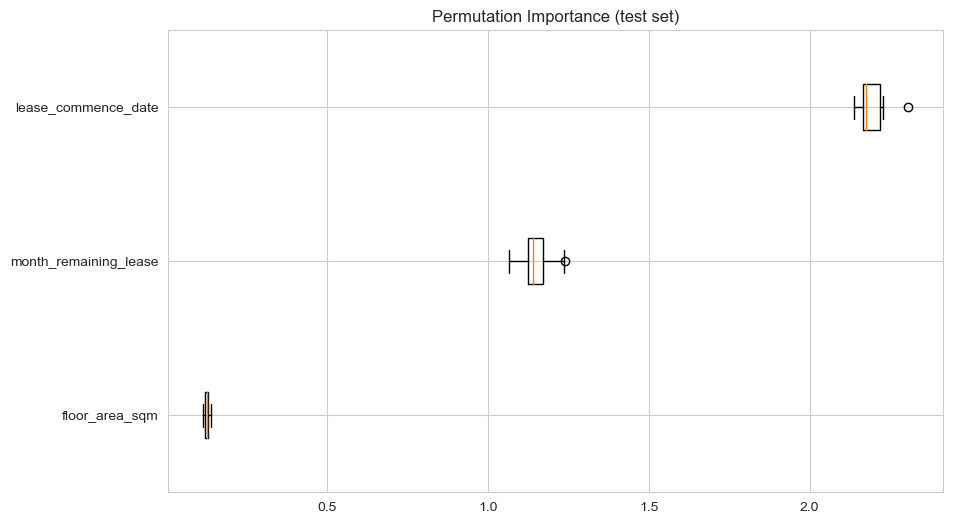

In [425]:
# Random Forest Regressor
print(town, "-", flat_type)
random_forest_model = PredictionModel('RandomForestRegressor')
random_forest_model.train_model(town, flat_type)
random_forest_regressor = random_forest_model.fit()
y_pred = random_forest_model.predict(random_forest_regressor)
random_forest_model.evaluate(y_pred)
random_forest_model.plot_importance(random_forest_regressor)
random_forest_model.plot_permutation(random_forest_regressor)

WOODLANDS - 4 ROOM
Mean Squared Error: 37359.7498
R2 score: 0.7235137693936735


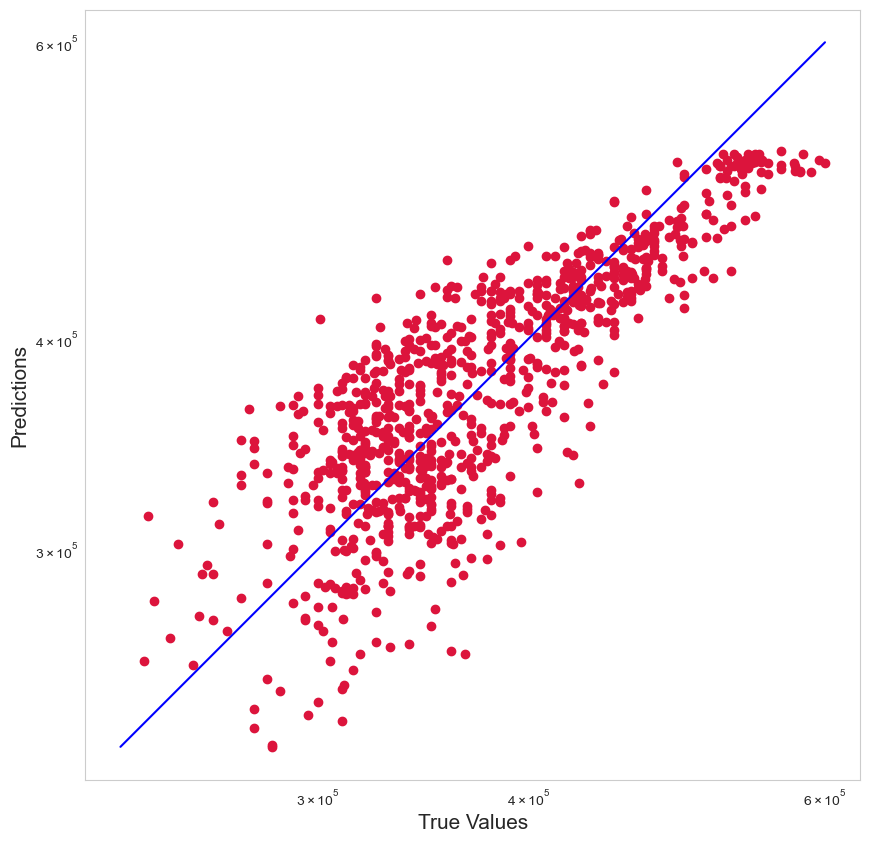

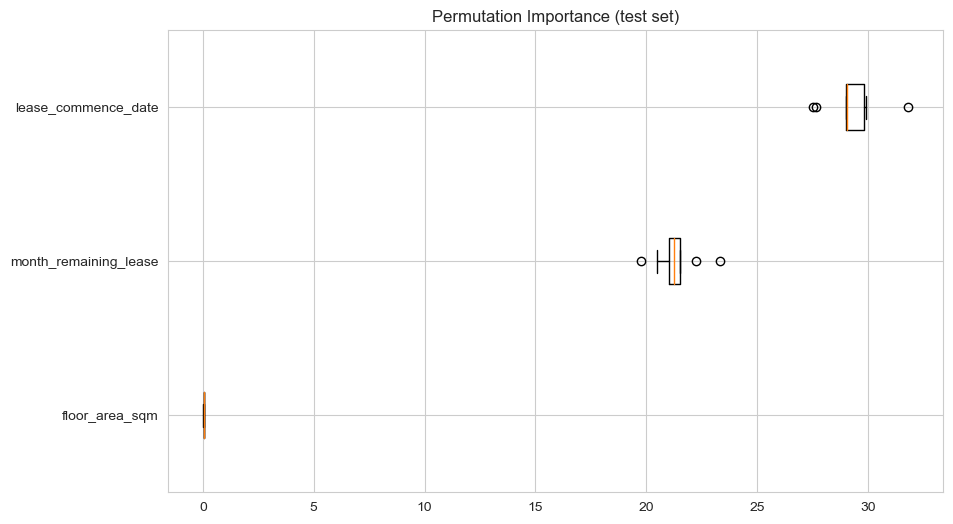

In [426]:
# Linear Regressor
print(town, "-", flat_type)
linear_model = PredictionModel('LinearRegression')
linear_model.train_model(town, flat_type)
linear_regressor = linear_model.fit()
y_pred = linear_model.predict(linear_regressor)
linear_model.evaluate(y_pred)
linear_model.plot_permutation(linear_regressor)

WOODLANDS - 4 ROOM
Mean Squared Error: 26988.9145
R2 score: 0.8557099362990054


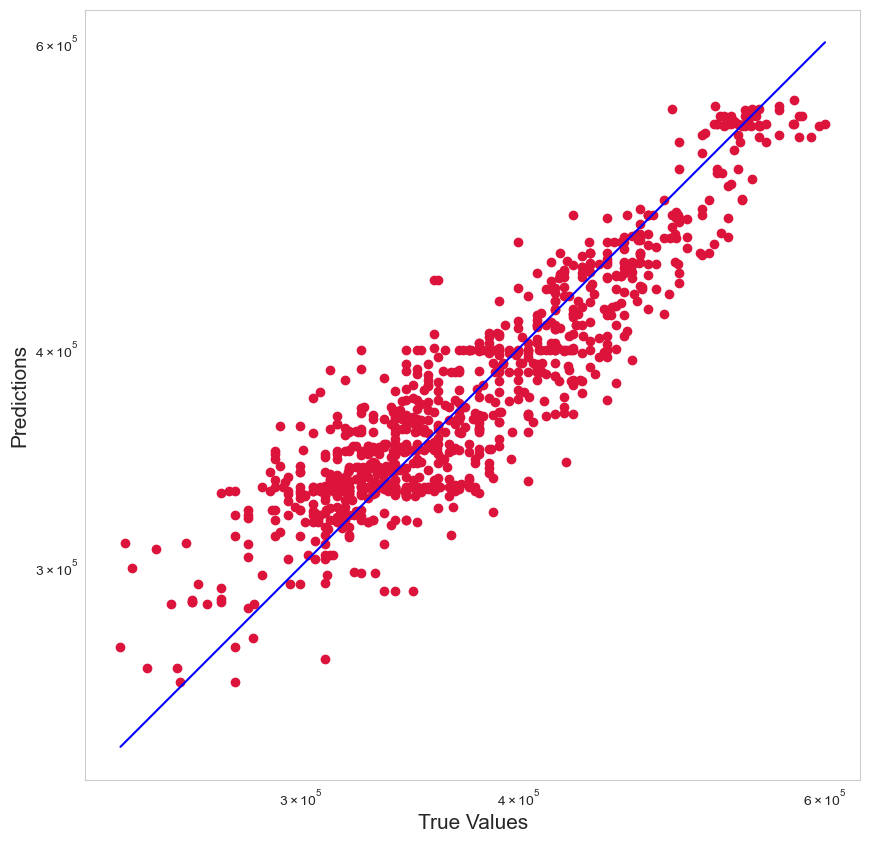

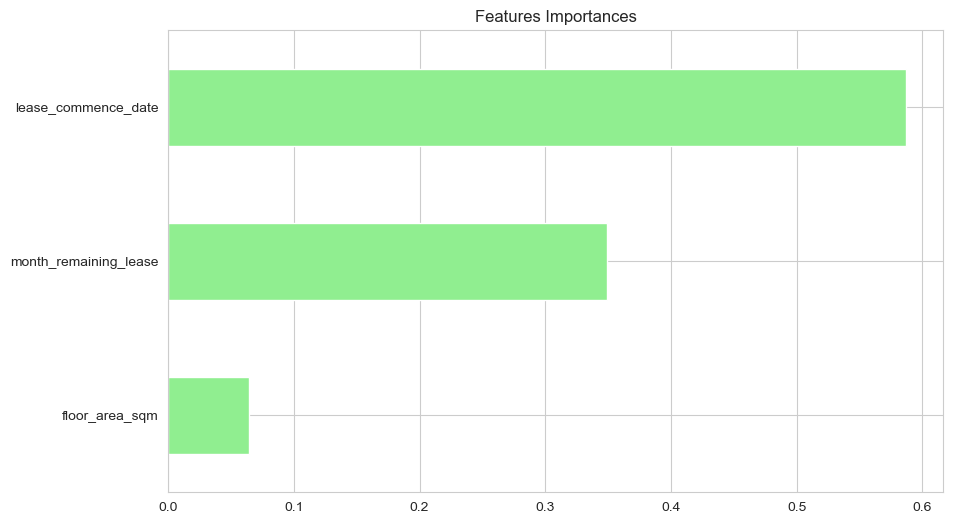

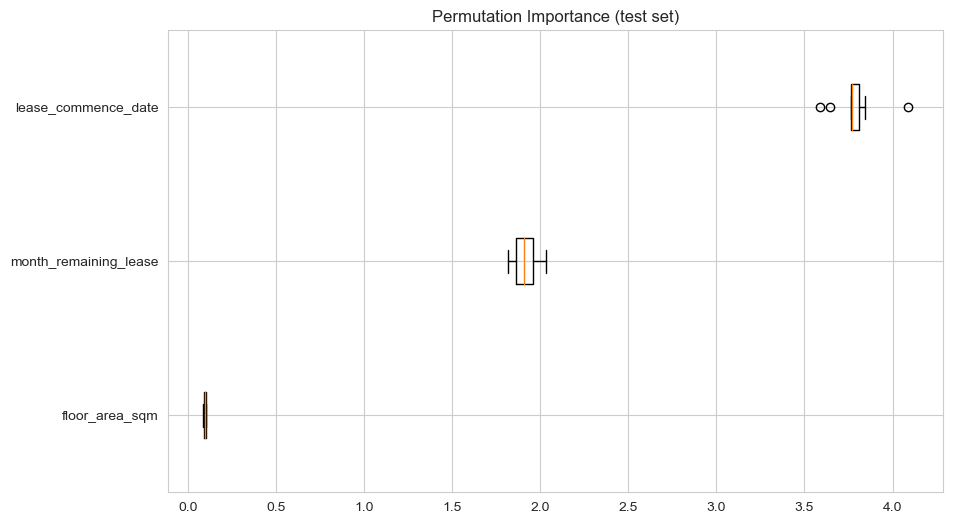

In [427]:
# Gradient Boosting Regressor
print(town, "-", flat_type)
gb_model = PredictionModel('GradientBoostingRegressor')
gb_model.train_model(town, flat_type)
gb_regressor = gb_model.fit()
y_pred = gb_model.predict(gb_regressor)
gb_model.evaluate(y_pred)
gb_model.plot_importance(gb_regressor)
gb_model.plot_permutation(gb_regressor)

## Possible Improvements to Be Made

1. Consider additional data columns that may possibly affect prices of flats
- Distance to nearest MRT station
- Distance to recreational buildings (e.g. Shopping malls, Community Centers, Parks)
- PSI of location
- Population in Singapore
- Resident marriages for the year
- Cost of landed properties
- Cost of condominiums
- Cost of living in Singapore

2. Consider removal of outliers
- Removal of data affected by unexpected world affairs such as COVID